In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from tqdm import tqdm_notebook
import scipy.integrate as integrate
import copy
import seaborn as sns
from pathlib import Path

In [57]:
MODEL_DIRECTORY = Path('../model/')
MAIN_DIRECTORY = Path('../')

In [58]:
def read_file(filename):
    df = pd.read_csv(filename, delimiter='\\s+')
    df = df.apply(pd.to_numeric, errors='coerce')
    try:
        df.dropna(subset = ['phot_g_mean_mag','bp_rp'], inplace = True)
    except:
        pass
    return df

def interp (a, b, c): 
    """get mass of starS with definite magnitude"""
    func = interp1d(a, b)
    return func(c)

In [59]:
singles_data = read_file(MODEL_DIRECTORY / 'model_separated_singles_500pc_manystars_flat.txt')
singles_data = singles_data[singles_data['bp-rp, mag']>0]

binaries_data = read_file(MODEL_DIRECTORY / 'model_separated_binaries_500pc_manystars_flat.txt')
binaries_data = binaries_data[binaries_data['bp-rp, mag']>0]

In [60]:
isochrone = read_file(MODEL_DIRECTORY / 'isochrone_model_8.38.txt')

In [62]:
len(singles_data[singles_data['Mass']>0])

3522

In [67]:
degree = 10
popt1 = np.polyfit(singles_data['bp-rp, mag'], singles_data['g, mag'], degree)
func_iso = np.poly1d(popt1)

isochrone_poly = pd.DataFrame(data = {'bp-rp, mag' : np.linspace(singles_data['bp-rp, mag'].min()-0.05, 
                                                       singles_data['bp-rp, mag'].max()+0.05, 500)})
isochrone_poly['g, mag'] = func_iso(isochrone_poly['bp-rp, mag'])

singles_true_data = singles_data[singles_data['Mass']>0]

popt2 = np.polyfit(singles_true_data['bp-rp, mag'], singles_true_data['g, mag'], degree)
func_iso = np.poly1d(popt2)

isochrone_poly_true = pd.DataFrame(data = {'bp-rp, mag' : np.linspace(singles_data['bp-rp, mag'].min()-0.05, 
                                                       singles_data['bp-rp, mag'].max()+0.05, 500)})
isochrone_poly_true['g, mag'] = func_iso(isochrone_poly_true['bp-rp, mag'])

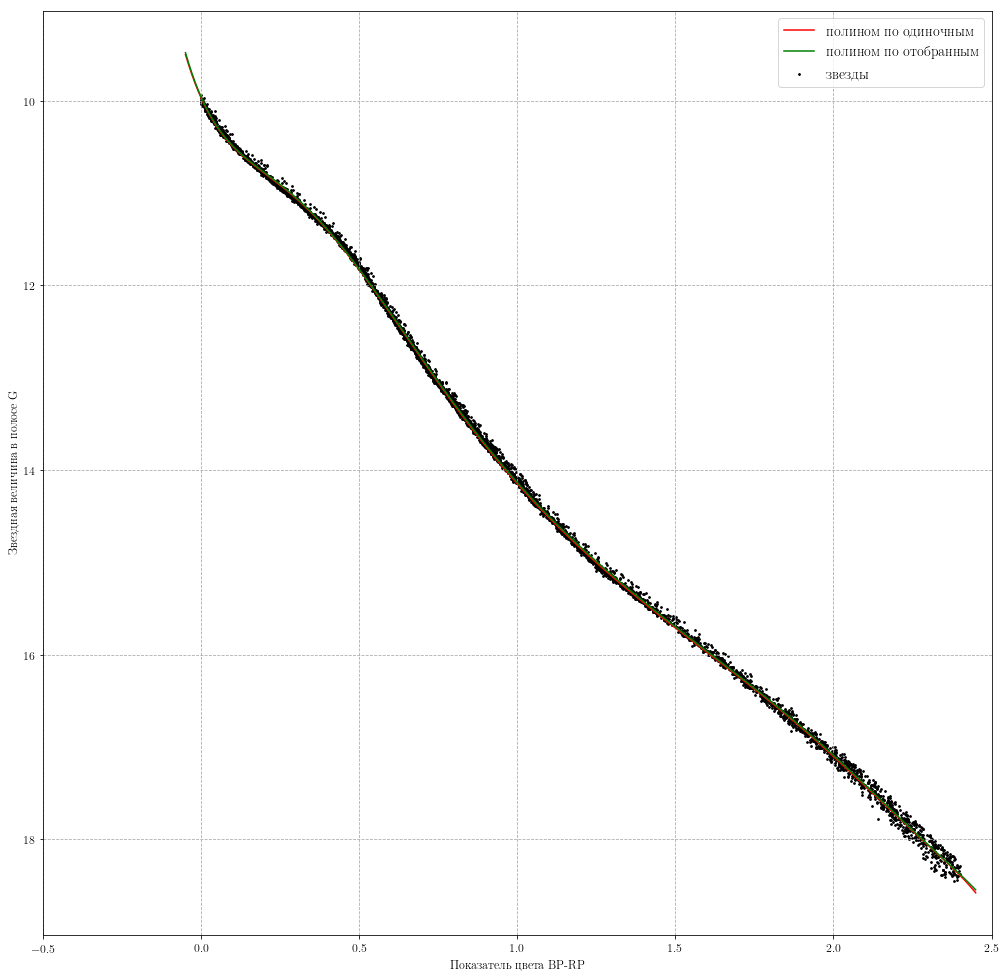

In [68]:
fig, ax = plt.subplots(figsize=(17, 17))
ax.scatter (singles_data['bp-rp, mag'] , singles_data['g, mag'] , c ='black', s = 3, label ='звезды')

#ax.plot(isochrone['G_BPmag']-isochrone['G_RPmag'], isochrone['Gmag'] + 5 * np.log10(500) - 5, c ='green', lw = 1.5, label ='изохрона') 
ax.plot(isochrone_poly_true['bp-rp, mag'], isochrone_poly_true['g, mag'] , c ='red', lw = 1.5, label ='полином по одиночным')
ax.plot(isochrone_poly['bp-rp, mag'], isochrone_poly['g, mag'] , c ='green', lw = 1.5, label ='полином по отобранным') 



ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()
ax.invert_yaxis()
ax.set_xlim(-0.5,2.5)
#ax.set_xlim(-0.5,2.5)

plt.rcParams.update({'font.size': 12})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
ax.legend(fontsize = 15)
#plt.savefig("polynomial_approximation.pdf", bbox_inches = 'tight')
plt.show()

In [65]:
abs((popt1-popt2) / popt1)

array([6.61106128e-01, 8.16055335e-01, 1.31650261e+00, 1.42573006e+03,
       7.89237333e-01, 2.91088599e-01, 1.38179919e-01, 7.21932738e-02,
       4.15392850e-02, 1.52528363e-02, 1.04920625e-03])

In [50]:
abs((popt1-popt2) / popt1)

array([1.15600885e-01, 1.31929302e-01, 1.58414343e-01, 2.11404882e-01,
       3.79954567e-01, 3.12787560e+00, 2.15006007e-01, 9.09583533e-02,
       5.15126425e-02, 1.68741023e-02, 5.27023441e-04])

In [71]:
degree = 15
popt2 = np.polyfit(singles_true_data['bp-rp, mag'], singles_true_data['g, mag'], degree)
func_iso = np.poly1d(popt2)

isochrone_poly_true = pd.DataFrame(data = {'bp-rp, mag' : np.linspace(singles_true_data['bp-rp, mag'].min()-0.05, 
                                                       singles_true_data['bp-rp, mag'].max()+0.05, 500)})
isochrone_poly_true['g, mag'] = func_iso(isochrone_poly_true['bp-rp, mag'])


singles_data['Gmag_new'] = singles_data['g, mag'] - func_iso(singles_data['bp-rp, mag'])
binaries_data['Gmag_new'] = binaries_data['g, mag'] - func_iso(binaries_data['bp-rp, mag'])

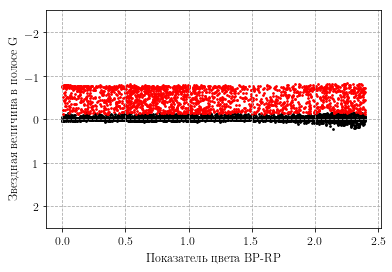

In [72]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter (singles_data['bp-rp, mag'] , singles_data['Gmag_new'] , c ='black', s = 3, label ='звезды')
ax.scatter (binaries_data['bp-rp, mag'] , binaries_data['Gmag_new'] , c ='red', s = 3, label ='звезды')

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()

ax.set_ylim(-2.5,2.5)
ax.invert_yaxis()

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
#ax.legend(fontsize = 15)
#plt.savefig("horizontal_sequence.pdf", bbox_inches = 'tight')
plt.show()

In [73]:
all_stars_data = pd.concat([binaries_data, singles_data])

In [87]:
num_stars = len(all_stars_data)
profile = pd.DataFrame(data = {'x' : np.linspace(-2, 1, 701)})
kde = KernelDensity(kernel='epanechnikov', bandwidth=0.15)
kde.fit(all_stars_data[['Gmag_new']].to_numpy())

profile['density'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) 
profile['density'] *= num_stars

def f(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / c) + d

row_max = profile['density'].idxmax()
popt, pcov = curve_fit(f, profile.iloc[row_max-5:row_max+155, 0], profile.iloc[row_max-5:row_max+155, 1],
                           bounds=([0, profile.iloc[row_max, 0]-0.1, 0, -0.1],
                                   [30000, profile.iloc[row_max, 0]+0.1, 0.1, 0.1]),
                          maxfev=9000)

profile_gauss = pd.DataFrame(data={'x': profile['x']})
profile_gauss['density'] = f(profile_gauss['x'], *popt)

Text(0.5, 0, '$G_{new}$')

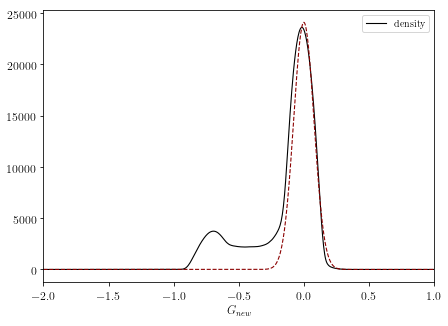

In [88]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(profile['x'], profile['density'], lw = 1.1, color = 'black')
ax.plot(profile_gauss['x'], profile_gauss['density'], lw = 1.1, ls='--', color='darkred', label='_nolabel')
ax.set_xlim(-2, 1)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('$G_{new}$')
#fig.savefig(f"model_profile_500pc_manystars_power2.pdf", bbox_inches = 'tight')

Text(0.5, 0, '$G_{new}$')

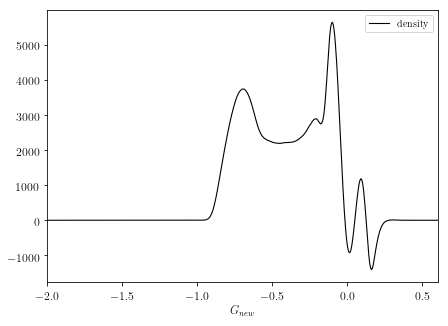

In [89]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(profile['x'], profile['density'] - profile_gauss['density'], lw = 1.1, color = 'black')
ax.set_xlim(-2, 0.6)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('$G_{new}$')
#fig.savefig(f"{CLUSTER}_profile_binaries.pdf", bbox_inches = 'tight')

In [90]:
difference = profile['density'] - profile_gauss['density']
difference[difference < 0] = 0

number_of_multiples = int(integrate.trapz(difference, profile['x']))

In [91]:
number_of_multiples / len(all_stars_data)

0.3483834211650762